In [26]:
# !pip uninstall -y numpy
# !pip install numpy==1.25.2
# !pip install pandas==2.0.3
# !pip install scipy==1.13.1
# !pip install --upgrade gensim tensorflow #Upgrade gensim and tensorflow
# !pip install scikit-learn nltk imblearn

In [ ]:
# !pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.1 MB/s eta 0:00:00


: 

In [27]:
import re
import string
import emoji
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from tqdm import tqdm

import nltk
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
df = pd.read_csv('prabowo_menjawab.csv')
df.head()

,Nama Akun,Komentar,Sumber
0,@azzahrasyamilarahmat5028,11/100 Is Real...,Narasi Newsroom
1,@faritrohman3969,Saya kecewa cuma gara gara beberapa anak kelua...,Narasi Newsroom
2,@moradepadli5676,Prabowo aneh,Narasi Newsroom
3,@anggaviali1188,Nonton tanpa baca komen itu lebih baik,Narasi Newsroom
4,@derikoswaranda3500,woyyy mana ini?? ko komenan ga ada yg pro pa w...,Narasi Newsroom


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15020 entries, 0 to 15019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama Akun  15017 non-null  object
 1   Komentar   15016 non-null  object
 2   Sumber     15020 non-null  object
dtypes: object(3)
memory usage: 352.2+ KB


In [108]:
print(f'jumlah data sebelum dropna : {len(df)}')
df = df.dropna()
print(f'jumlah data setelah dropna : {len(df)}')

jumlah data sebelum dropna : 15020
jumlah data setelah dropna : 15013


In [109]:
print(f'Jumlah data duplikat      : {df["Komentar"].duplicated().sum()}')

df = df.drop_duplicates(subset=['Komentar'])
print(f'Setelah handling duplikat : {df["Komentar"].duplicated().sum()}')

Jumlah data duplikat      : 380
Setelah handling duplikat : 0


In [110]:
df = df.reset_index(drop=True) #reset index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14633 entries, 0 to 14632
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama Akun  14633 non-null  object
 1   Komentar   14633 non-null  object
 2   Sumber     14633 non-null  object
dtypes: object(3)
memory usage: 343.1+ KB


# preprocessing teks

In [96]:
def cleaningText(text):
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

In [97]:
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

In [98]:
# Variabel teks kepanjangan
count_too_long = 0

def tokenizingText(text):
    global count_too_long  

    if isinstance(text, str):
        # Tahap tokenisasi: memecah teks menjadi unit kata (token) menggunakan word_tokenize dari NLTK
        tokens = word_tokenize(text)

        max_token_length = 350
        if len(tokens) > max_token_length:
            count_too_long += 1  # Menambah hitungan jika token terlalu panjang
            tokens = tokens[:max_token_length]  # Memotong token agar sesuai batas panjang

        return tokens  # Mengembalikan list token
    else:
        return []  #kembalikan list kosong jika input bukan string

In [99]:
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

In [100]:
listStopwords = set(stopwords.words('indonesian'))
listStopwords1 = set(stopwords.words('english'))
listStopwords.update(listStopwords1)
listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","kali","lu","beliau"])

def filteringText(text): # Menghapus stopwords dalam teks
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [101]:
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [102]:
# Load kamus slang dari GitHub
slang_df = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv')
slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))

# Fungsi untuk memperbaiki kata slang
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        fixed_words.append(slang_dict.get(word.lower(), word))

    return ' '.join(fixed_words)

In [103]:
df.isna().sum()

Nama Akun    0
Komentar     0
Sumber       0
dtype: int64

In [111]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['Komentar'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

print(f"Handling  {count_too_long} data terlalu panjang melebihi 350 token")
print(f"Jumlah data yang berhasil diproses: {len(df)}")

Handling  33 data terlalu panjang melebihi 350 token
Jumlah data yang berhasil diproses: 14633


In [ ]:
# Load model dan tokenizer
tokenizer = AutoTokenizer.from_pretrained("Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis")

# Buat pipeline klasifikasi
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=-1)

tqdm.pandas() # Tampilkan progress bar saat apply

# Prediksi sentimen pada kolom 'text_akhir'
df['sentimen'] = df['text_akhir'].progress_apply(lambda x: pipe(x)[0]['label'])

In [66]:
df_label = pd.read_csv('labeled_sentimen.csv')

In [67]:
print(f'jumlah data sebelum dropna : {len(df_label)}')
df_label = df_label.dropna()
print(f'jumlah data setelah dropna : {len(df_label)}')

jumlah data sebelum dropna : 14633
jumlah data setelah dropna : 14261


In [68]:
print(df_label['sentimen'].value_counts())

sentimen
Negative    8316
Neutral     3683
Positive    2262
Name: count, dtype: int64


Preprocessing Text

In [56]:
import ast

# Konversi string ke list untuk seluruh kolom
df_label['text_stopword'] = df_label['text_stopword'].apply(ast.literal_eval)

ValueError: malformed node or string: ['real']

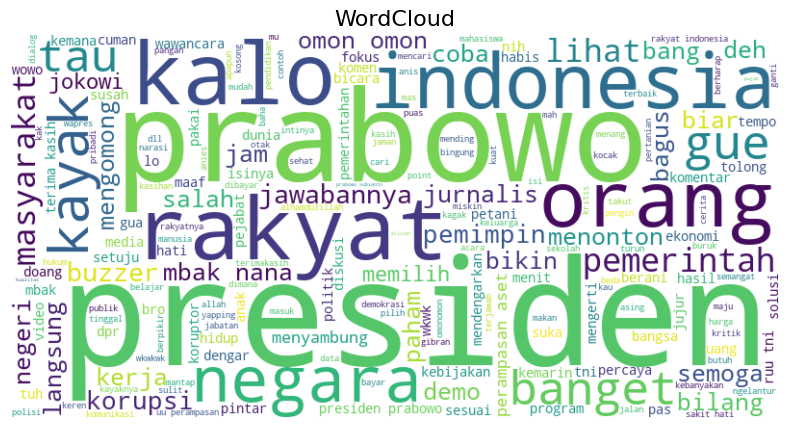

In [73]:
import ast
df_label['text_stopword'] = df_label['text_stopword'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 3. Gabungkan dan filter kata
all_tokens = [word for tokens in df_label['text_stopword'] for word in tokens if word not in listStopwords]
all_words = ' '.join(all_tokens)

# 4. Generate dan tampilkan wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'WordCloud', fontsize=16)
plt.axis('off')
plt.show()

In [74]:
print(f"Jumlah data sebelum SMOTE: {len(df_label)}")
print("Distribusi awal:\n", df_label['sentimen'].value_counts().to_string())

Jumlah data sebelum SMOTE: 14261
Distribusi awal:
 sentimen
Negative    8316
Neutral     3683
Positive    2262


In [76]:
# Oversampling dengan SMOTE setelah TF-IDF
print(f"Jumlah data sebelum SMOTE: {len(df_label)}")
print("Distribusi awal:\n", df_label['sentimen'].value_counts().to_string())

tfidf = TfidfVectorizer(max_features=10000, stop_words=list(listStopwords), ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df_label['text_akhir']).toarray()

y = pd.get_dummies(df_label['sentimen']).values
smote = SMOTE(random_state=42)
X_tfidf_smote, y_smote = smote.fit_resample(X_tfidf, np.argmax(y, axis=1))
y_smote = pd.get_dummies(y_smote).values

df_balanced = pd.DataFrame({'text_akhir': [' '.join(doc) for doc in tfidf.inverse_transform(X_tfidf_smote)], 'sentimen': np.argmax(y_smote, axis=1)})
df_balanced['sentimen'] = df_balanced['sentimen'].map({0: 'negatif', 1: 'netral', 2: 'positif'})
print(f"Jumlah data setelah SMOTE: {len(df_balanced)}")
print("Distribusi setelah SMOTE:\n", df_balanced['sentimen'].value_counts().to_string())

Jumlah data sebelum SMOTE: 14261
Distribusi awal:
 sentimen
Negative    8316
Neutral     3683
Positive    2262


c:\Users\lenovo\ProyekNLP\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Jumlah data setelah SMOTE: 24948
Distribusi setelah SMOTE:
 sentimen
negatif    8316
netral     8316
positif    8316


In [84]:
# Fungsi evaluasi
def evaluate_model(y_true, y_pred, set_name=""):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAkurasi {set_name}: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred, target_names=['negatif', 'netral', 'positif']))
    return accuracy

**Data Splitting**

In [77]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf_smote, y_smote, test_size=0.2, random_state=42)

In [82]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Fungsi untuk membuat model MLP
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(
        hp.Int('units_1', min_value=128, max_value=512, step=64), 
        activation='relu', 
        input_shape=(X_tfidf_smote.shape[1],),
        kernel_regularizer=l2(0.001)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Hidden layers
    model.add(Dense(
        hp.Int('units_2', min_value=128, max_value=512, step=64),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Menentukan tuner yang digunakan (RandomSearch di sini)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Mencari model dengan akurasi validasi terbaik
    max_trials=5,  # Jumlah trial eksperimen yang akan dicoba
    executions_per_trial=1,  # Berapa kali eksperimen untuk setiap trial
    directory='my_dir',  # Lokasi penyimpanan hasil tuning
    project_name='mlp_tuning'
)

# Callbacks untuk menghentikan pelatihan lebih awal jika model sudah berhenti meningkatkan performa
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Mulai proses tuning
tuner.search(
    X_train1, y_train1,
    epochs=30,
    validation_data=(X_test1, y_test1),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=64
)

# Menampilkan hasil tuning
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Trial 5 Complete [00h 06m 14s]
val_accuracy: 0.8671342730522156

Best val_accuracy So Far: 0.8693386912345886
Total elapsed time: 00h 40m 00s
Best hyperparameters: {'units_1': 192, 'dropout_1': 0.4, 'units_2': 128, 'dropout_2': 0.4, 'learning_rate': 0.0010809378085025996}


In [83]:
# Bangun kembali model dengan hyperparameter terbaik
model1 = Sequential([
    Dense(192, activation='relu', input_shape=(X_tfidf_smote.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 kelas
])

# Compile dengan learning rate terbaik
model1.compile(
    optimizer=Adam(learning_rate=0.0010809378085025996),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training ulang model final
history = model1.fit(
    X_train1, y_train1,
    epochs=30,
    batch_size=64,
    validation_data=(X_test1, y_test1),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


c:\Users\lenovo\ProyekNLP\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5558 - loss: 1.0964 - val_accuracy: 0.7796 - val_loss: 0.8089 - learning_rate: 0.0011
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8156 - loss: 0.7514 - val_accuracy: 0.8012 - val_loss: 0.8041 - learning_rate: 0.0011
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8528 - loss: 0.6987 - val_accuracy: 0.8156 - val_loss: 0.8037 - learning_rate: 0.0011
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8675 - loss: 0.6703 - val_accuracy: 0.8317 - val_loss: 0.7893 - learning_rate: 0.0011
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8800 - loss: 0.6476 - val_accuracy: 0.8297 - val_loss: 0.7812 - learning_rate: 0.0011
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8931 - loss: 0.6129 - val_accuracy: 0.8353 - val_loss: 0.7779 - learning_rate: 0.0011
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8975 - loss

In [85]:
y_pred_train1 = np.argmax(model1.predict(X_train1), axis=1)
y_pred_test1 = np.argmax(model1.predict(X_test1), axis=1)
y_train1_cat = np.argmax(y_train1, axis=1)
y_test1_cat = np.argmax(y_test1, axis=1)
train_acc1 = evaluate_model(y_train1_cat, y_pred_train1, "Training")
test_acc1 = evaluate_model(y_test1_cat, y_pred_test1, "Testing")

624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Akurasi Training: 96.93%
              precision    recall  f1-score   support

     negatif       0.99      0.97      0.98      6681
      netral       0.92      0.99      0.96      6661
     positif       1.00      0.95      0.97      6616

    accuracy                           0.97     19958
   macro avg       0.97      0.97      0.97     19958
weighted avg       0.97      0.97      0.97     19958


Akurasi Testing: 85.91%
              precision    recall  f1-score   support

     negatif       0.90      0.75      0.82      1635
      netral       0.79      0.92      0.85      1655
     positif       0.91      0.91      0.91      1700

    accuracy                           0.86      4990
   macro avg       0.86      0.86      0.86      4990
weighted avg       0.86      0.86      0.86      4990



In [86]:
sentences = [text.split() for text in df_balanced['text_akhir']]
w2v_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4, epochs=20)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_balanced['text_akhir'])
X_seq = tokenizer.texts_to_sequences(df_balanced['text_akhir'])
max_len = 100  # Dikurangi untuk teks pendek
X_pad = pad_sequences(X_seq, maxlen=max_len)

embedding_matrix = np.zeros((10000, 200))
for word, i in tokenizer.word_index.items():
    if i < 10000 and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [88]:
# --- Skema 2: LSTM + Word2Vec (80/20) ---
print("\n=== Skema 2: LSTM + Word2Vec (80/20) ===")

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pad, y_smote, test_size=0.2, random_state=42)

model2 = Sequential([
    Embedding(10000, 200, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.005))),
    LSTM(128),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model2.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(X_train2, y_train2, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stopping, lr_scheduler], verbose=1)

y_pred_train2 = np.argmax(model2.predict(X_train2), axis=1)
y_pred_test2 = np.argmax(model2.predict(X_test2), axis=1)
y_train2_cat = np.argmax(y_train2, axis=1)
y_test2_cat = np.argmax(y_test2, axis=1)
train_acc2 = evaluate_model(y_train2_cat, y_pred_train2, "Training")
test_acc2 = evaluate_model(y_test2_cat, y_pred_test2, "Testing")



=== Skema 2: LSTM + Word2Vec (80/20) ===
Epoch 1/30


c:\Users\lenovo\ProyekNLP\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


281/281 ━━━━━━━━━━━━━━━━━━━━ 179s 621ms/step - accuracy: 0.5290 - loss: 3.0332 - val_accuracy: 0.6167 - val_loss: 1.1979 - learning_rate: 5.0000e-04
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 189s 574ms/step - accuracy: 0.6566 - loss: 1.1080 - val_accuracy: 0.6854 - val_loss: 0.9046 - learning_rate: 5.0000e-04
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 149s 532ms/step - accuracy: 0.7174 - loss: 0.8420 - val_accuracy: 0.7320 - val_loss: 0.7551 - learning_rate: 5.0000e-04
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 150s 533ms/step - accuracy: 0.7850 - loss: 0.6711 - val_accuracy: 0.7831 - val_loss: 0.6363 - learning_rate: 5.0000e-04
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 149s 532ms/step - accuracy: 0.8294 - loss: 0.5480 - val_accuracy: 0.8041 - val_loss: 0.6058 - learning_rate: 5.0000e-04
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 150s 536ms/step - accuracy: 0.8604 - loss: 0.4584 - val_accuracy: 0.8136 - val_loss: 0.5815 - learning_rate: 5.0000e-04
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 149s 532ms/

In [89]:
# --- Skema 3: Dense + TF-IDF (70/30) ---
print("\n=== Skema 3: Dense + TF-IDF (70/30) ===")
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_tfidf_smote, y_smote, test_size=0.3, random_state=42)

model3 = Sequential([
    Input(shape=(10000,)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])
model3.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model3.fit(X_train3, y_train3, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping, lr_scheduler], verbose=1)

y_pred_train3 = np.argmax(model3.predict(X_train3), axis=1)
y_pred_test3 = np.argmax(model3.predict(X_test3), axis=1)
y_train3_cat = np.argmax(y_train3, axis=1)
y_test3_cat = np.argmax(y_test3, axis=1)
train_acc3 = evaluate_model(y_train3_cat, y_pred_train3, "Training")
test_acc3 = evaluate_model(y_test3_cat, y_pred_test3, "Testing")


=== Skema 3: Dense + TF-IDF (70/30) ===
Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.5231 - loss: 1.4197 - val_accuracy: 0.7407 - val_loss: 0.8319 - learning_rate: 5.0000e-04
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8058 - loss: 0.7378 - val_accuracy: 0.8082 - val_loss: 0.7834 - learning_rate: 5.0000e-04
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8676 - loss: 0.6410 - val_accuracy: 0.8094 - val_loss: 0.7786 - learning_rate: 5.0000e-04
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.8882 - loss: 0.5956 - val_accuracy: 0.8077 - val_loss: 0.7822 - learning_rate: 5.0000e-04
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8990 - loss: 0.5665 - val_accuracy: 0.8220 - val_loss: 0.7895 - learning_rate: 5.0000e-04
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9237 - loss: 0.5143 - val_accuracy: 0.8317 - val_loss: 0.7460 - learning_rate: 2.5000e-04
Epoch 7/20


In [ ]:
# Tokenizer & padding untuk LSTM dan CNN
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=30)
vocab_size = len(tokenizer.word_index) + 1

: 

In [ ]:
# Skema 2 - LSTM (70/30)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pad, labels_cat, test_size=0.3, random_state=42)

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=30),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train2, y_train2, epochs=10, validation_data=(X_test2, y_test2), verbose=1)

Epoch 1/10


c:\Users\lenovo\ProyekNLP\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


321/321 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5898 - loss: 0.9093 - val_accuracy: 0.7212 - val_loss: 0.6757
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7757 - loss: 0.5493 - val_accuracy: 0.7476 - val_loss: 0.5989
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8544 - loss: 0.3750 - val_accuracy: 0.7428 - val_loss: 0.6382
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8936 - loss: 0.2903 - val_accuracy: 0.7353 - val_loss: 0.6864
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9090 - loss: 0.2481 - val_accuracy: 0.7339 - val_loss: 0.7843
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9232 - loss: 0.2104 - val_accuracy: 0.7385 - val_loss: 0.8941
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9396 - loss: 0.1709 - val_accuracy: 0.7235 - val_loss: 0.9845
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9475 - loss: 0.1475 - val_accuracy: 0.72

: 

In [ ]:
# Skema 3 - CNN (80/20)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_pad, labels_cat, test_size=0.2, random_state=42)

model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=30),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(num_classes, activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train3, y_train3, epochs=10, validation_data=(X_test3, y_test3), verbose=1)

Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6235 - loss: 0.8882 - val_accuracy: 0.7438 - val_loss: 0.6329
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7942 - loss: 0.5195 - val_accuracy: 0.7513 - val_loss: 0.6091
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8776 - loss: 0.3352 - val_accuracy: 0.7540 - val_loss: 0.6570
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9178 - loss: 0.2310 - val_accuracy: 0.7386 - val_loss: 0.7909
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9382 - loss: 0.1726 - val_accuracy: 0.7468 - val_loss: 0.8804
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9562 - loss: 0.1281 - val_accuracy: 0.7434 - val_loss: 0.9683
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9633 - loss: 0.1023 - val_accuracy: 0.7356 - val_loss: 1.0643
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9672 - loss: 0.0876 - val_accu

: 